In this problem we are examining dark matter density curves and how they effect the rotation curve of orbitting objects. We are using MCMC to find how sensitive our model is to r0 and p0 values. 

In this next code chunk we import the packages that we will use throughout the problem.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import emcee
import seaborn as sns

Now we are going to import and clean our data a little bit, making them into float rather then a string. 

In [4]:
planets = pd.read_csv('planets_rot.csv')
planets = planets[1:-1]
planets.head()

planets['km/s'] = planets['km/s'].str.replace(r'\[|\]', '').astype(float)

planets['km'] = planets['km'].str.replace(r'\[|\]', '').astype(float)

planets['km/s.1'] = planets['km/s.1'].str.replace(r'\[|\]', '').astype(float)



1    47.9
2    35.0
3    29.8
4    24.1
5    13.1
6     9.7
7     6.8
8     5.4
Name: km/s, dtype: float64
1    47.9
2    35.0
3    29.8
4    24.1
5    13.1
6     9.7
7     6.8
8     5.4
Name: km/s, dtype: float64


1    3351.472149
2      75.526751
3     165.934935
4     754.597505
5     212.129521
6     167.054152
7     106.389917
8      17.572477
Name: km/s.1, dtype: float64

Now we are going to define function that will be used in our model.
       
Density profile: This function takes a radius(r) and p0 and r0 values and returns the density at that location. It is defined as the following:
     
$\rho(r) = \begin{cases} 
\rho_0, & \text{if } r < r_0 \\
0, & \text{otherwise}
\end{cases}$

M1n: This is a function used to find the total mass within a given radius. It takes a radius(r) and p0 and r0 values and takes the intergal of the density profile from 0 to r. It is defined as the following:
      
$M_{\text{in}}(r) = \int_0^r 4\pi \rho(r') r'^2 \, dr'$

Velocity: This is a function that finds the velocity of an object at a given radius. It does this by taking the in mass within the radius of the object, multiplying it by the gravitational constant, and dividing it by the radius of the object. It is defined as the following:

$v(r) = \sqrt{\frac{GM_{\text{in}}(r)}{r}}$
      
Notice that it might seem as though we are only using the velocity function, but the other two functions are used within the velocity function.
​


In [5]:
def density_profile(r, po0, ro0):
    if r < ro0:
        return po0
    else:
        return 0

def M1n(r, po0, ro0):
    lst = []
    integrand = lambda r_prime: 4 * np.pi * density_profile(r_prime, po0, ro0) * (r_prime**2)
    for r1 in r:
        
        result, _ = quad(integrand, 1E-6, r1)
        lst.append(result)
    
    return np.array(lst)

def velocity(r, po0, ro0, G: int = 6.6743e-11):
    M = M1n(r, po0, ro0)
    return np.sqrt(G * M / r)


Now we are going to define a functions that will be used in our MCMC emsemble. 

ln_likelihood: This function returns the likelihood of a given value. It does this by comparing the given value to the model that we have created. 

ln_prior: This function is essentially the walls for our walkers. Because we know that every r0 and p0 value must be positive, if either of them are negative, the function will return negative infinity. Thus preventing the walkers from moving in that direction because the likely hood of a negative infinity value is 0.
    
ln_pdf: This function tells us how return how likely a given value is. It first makes sure that the parameters are realistic using the ln_prior function. If they are, it then returns the likelihood of the value using the ln_likelihood function.

Using all three of these functions as well as the model we have created in the chunk above we now have everything needed to run our function

In [6]:
def ln_prior(params):
   
    po0, ro0 = params
    if po0 > 0 and ro0 > 0:
        return 0
    return -np.inf

def ln_likelihood(params, r, v_obs, v_err):
    po0, ro0 = params
    v_model_predicted = velocity(r, po0, ro0)
    return -0.5 * np.sum((((v_obs - v_model_predicted) **2) / v_err)**2)

def ln_pdf(params, r, v_obs, v_err):
    p = ln_prior(params)
    if p == -np.inf:
        return -np.inf
    return p + ln_likelihood(params, r, v_obs, v_err)

In the following chunk we are going to set up and run our MCMC ensemble. We are running around 30 walkers each for 4000 steps. We are only evaluating two dimensions, r0 and p0. This does take a little bit of time to run, so get prepared to sit tight.

In [7]:
nwalkers = 30  # Number of walkers
ndim = 2
nsteps = 4000
initial_positions = np.random.rand(nwalkers, ndim)  # Random initial positions for the walkers

# Run the MCMC sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_pdf, args=(planets['km'], planets['km/s'], planets['km/s.1']))

sampler.run_mcmc(initial_positions, nsteps)

# Get the chain of samples
samples = sampler.get_chain()


/var/folders/b5/jqnd0ktj68gcq3l3764mxkz80000gn/T/ipykernel_6305/711162651.py:12: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  result, _ = quad(integrand, 1E-6, r1)


In this chunk we check and make sure that our walkers converge into a certain range. Luckily for us, they do. So we then remove the steps during the burn in to have more accurate data. 

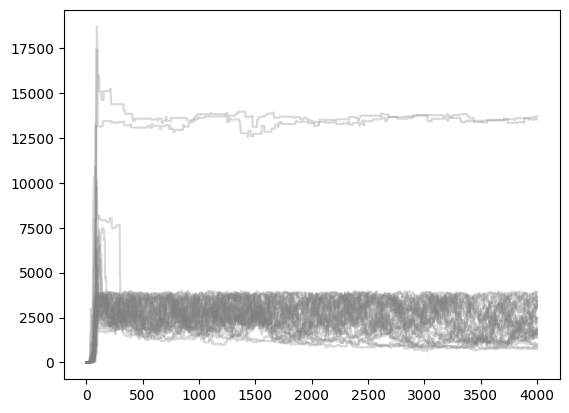

In [8]:
plt.plot(samples[:, :, 0],color='Grey', alpha=0.3)
samples2 = samples[2500:, :, :]

Now that the burn in has been removed, we can now plot the data to see the range they converged into. We can see the p0 range of 1500 to 4000
and a r0 range of 0.5e6 to 0.8e6. If you were to zoom out you might see a few walkers have haven't converged yet, but they eventually will and the majority have so we will just ignore them.

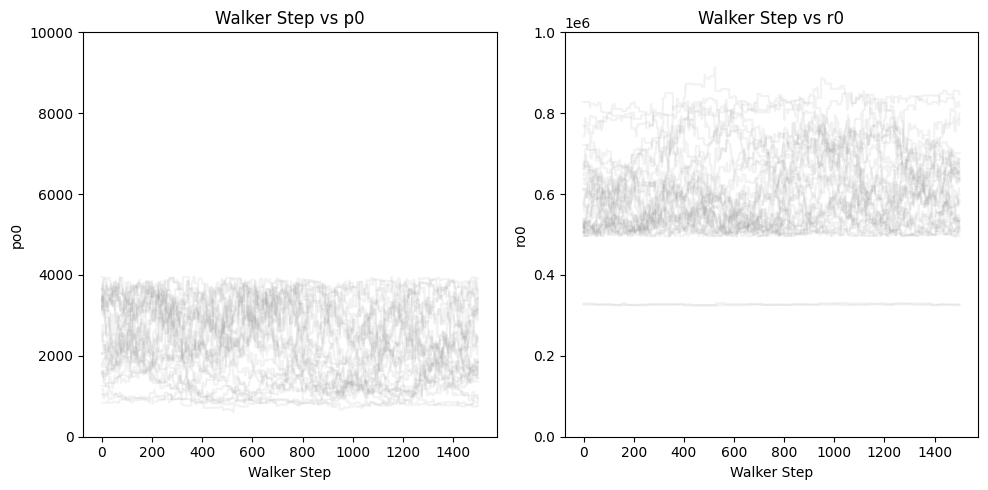

In [9]:

plt.figure(figsize=(10, 5))

# Plot for samples2[:,:,0]
plt.subplot(1, 2, 1)
plt.plot(samples2[:, :, 0], color='gray', alpha=0.1)
plt.title('Walker Step vs p0')
plt.ylabel('po0')
plt.xlabel('Walker Step')
plt.ylim(0, 1E4)

# Plot for samples2[:,:,1]
plt.subplot(1, 2, 2)
plt.plot(samples2[:, :, 1], color='gray', alpha=0.1)
plt.title('Walker Step vs r0')
plt.ylabel('ro0')
plt.xlabel('Walker Step')
plt.ylim(0, 1E6)

plt.tight_layout()
plt.show()


Now we create a KDE plot of the walkers steps to see how sensitive our model is to the p0 value and r0 value. This shows us the range of values that r0 and p0 can be in and have the model still work effectively. The little splotches of color are likely from the walkers not burning in yet.

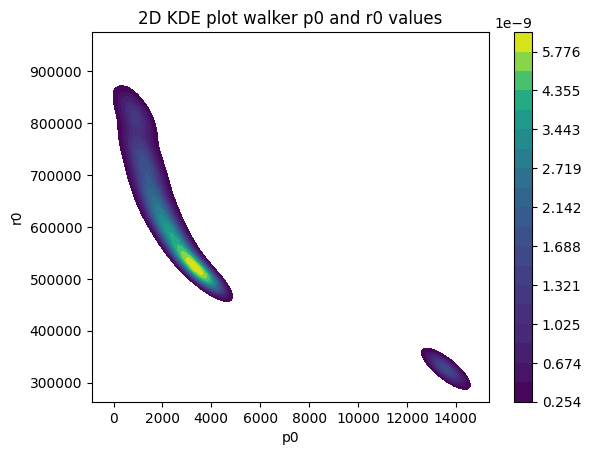

In [10]:
# plot a 2dkde plot of p0 and ro0
sample_x = samples2[:, :, 0].flatten()
sample_y = samples2[:, :, 1].flatten()
sns.kdeplot(x=sample_x, y=sample_y, fill=True, cmap='viridis',cbar=True,levels=20)
plt.xlabel('p0')
plt.ylabel('r0')
plt.title('2D KDE plot walker p0 and r0 values')
plt.show()
 

Now we are going to find the best fit values for r0 and p0. We do this by finding the median value for p0 and r0 for 100 random walker steps across all 30 walkers. Using these values we calculate out the velocity of various objects in our solar system. We then take the median velocity for each object and compare it to the actual velocity of the object. We then graph it to see how well model can predict the velocity of the objects. We find that it is incredibly accurate and that the standard deviation is very small, this means that the change in r0 and p0 is not significant enough to change the velocity of the objects by a significant amount in this range. 

[1    47.885869
2    35.029427
3    29.790711
4    24.131218
5     0.000000
6     0.000000
7     0.000000
8     0.000000
Name: km, dtype: float64, 1    47.871029
2    35.018571
3    29.781478
4    24.123739
5     0.000000
6     0.000000
7     0.000000
8     0.000000
Name: km, dtype: float64, 1    48.032637
2    35.136790
3    29.882018
4    24.205178
5     0.000000
6     0.000000
7     0.000000
8     0.000000
Name: km, dtype: float64, 1    48.065927
2    35.161142
3    29.902728
4    24.221957
5     0.000000
6     0.000000
7     0.000000
8     0.000000
Name: km, dtype: float64, 1    47.894808
2    35.035965
3    29.796271
4    24.135722
5     0.000000
6     0.000000
7     0.000000
8     0.000000
Name: km, dtype: float64, 1    47.733358
2    34.917860
3    29.695830
4    24.054362
5     0.000000
6     0.000000
7     0.000000
8     0.000000
Name: km, dtype: float64, 1    47.600617
2    34.820759
3    29.613250
4    23.987470
5     0.000000
6     0.000000
7     0.000000
8     0.000000
Nam

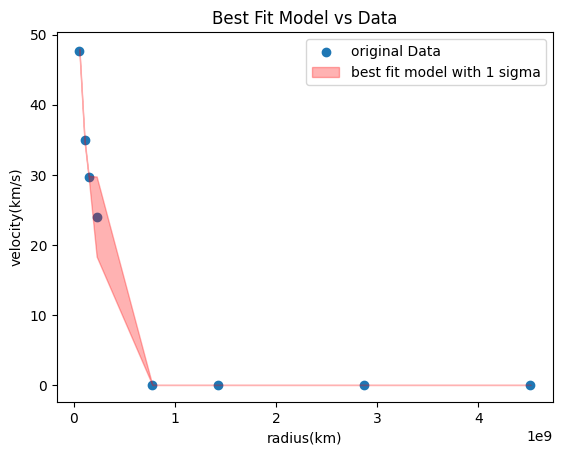

In [19]:
velos = []
for i in range(100):
    idx = np.random.randint(len(samples2))
    po0 = sample_x[idx]
    ro0 = sample_y[idx]
    velos.append(velocity(planets['km'], po0, ro0))
print(velos)

#plot median +- the standard deviation
velos = np.array(velos)
median = np.median(velos, axis=0)
std = np.std(velos, axis=0)
plt.scatter(planets['km'], median,label='original Data')
plt.fill_between(planets['km'], median - std, median + std, color='r', alpha=0.3, label='best fit model with 1 sigma')
plt.xlabel('radius(km)')
plt.ylabel('velocity(km/s)')
plt.title('Best Fit Model vs Data')
plt.legend()